# Machine Learning - Assignment 4

### Oscar Fabián Ñáñez Núñez - Juan Camilo Calero Espinosa
### ofnanezn - jccaleroe

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.layers.wrappers import TimeDistributed
from itertools import permutations
from operator import itemgetter

from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input, decode_predictions
import numpy as np
from keras.preprocessing import image
import operator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from keras import models, layers, optimizers
from keras.utils import multi_gpu_model
from keras.models import load_model
import warnings

warnings.filterwarnings('ignore')
folders = ["birds/toucan/tou", "birds/egret/egr", "birds/mandarin/man", "birds/wood_duck/wod", "birds/puffin/puf", 
           "birds/owl/owl"]
birds = ["toucan", "American_egret", "mandarin", "wood_duck", "puffin", "owl"]

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 1.

## 1a)
![title](nn.jpg)
where $a_{i}=\sum_{j}w_{j}^{i}z_{j}$ , $z_{i}=f_{i}(a_{i})$ for
$i=1,2,3,4$, $z_{5}=a_{5}$ (an input neuron), $f_{2}(x)=\textrm{relu}(x)$,
and $f_{1}(x)=f_{3}(x)=f_{4}(x)=\textrm{sigmoid}(x)$. $\textrm{relu}(x)$
corresponds to a rectifier linear unit transfer function defined as:
$$
\textrm{relu}(x)=\begin{cases}
x & \textrm{if }x\ge0\\
0 & \textrm{otherwise}
\end{cases}
$$

1.a Write a function to simulate the neural network:

In [2]:
def sigmoid(x, derivative=False):
    sigma_x = 1./(1+np.exp(-x))
    if not derivative:
        return sigma_x
    else:
        return sigma_x * (1 - sigma_x)
    
def relu(x, derivative=False):
    if not derivative:
        return max(0,x)
    else:
        return (1 if x > 0 else 0)

In [3]:
def forward_propagate(x, w):
    '''
    x: input value for neuron 5
    w: weights array in the following order
       [w13, w12, w14, w32, w42, w53, w54]
    Returns: a pair of arrays (a, z), where 
             a has the activation values for each neuron, and
             z the output values for each neuron
    '''
    w31, w21, w41, w32, w42, w53, w54 = w[0], w[1], w[2], w[3], w[4], w[5], w[6]
    z = np.zeros(5)
    a = np.zeros(5)
    # your code here
    a[4] = x
    z[4] = a[4]
    a[3] = w54*z[4]
    z[3] = sigmoid(a[3])
    a[2] = w53*z[4]
    z[2] = sigmoid(a[2])
    a[1] = w32*z[2] + w42*z[3]
    z[1] = relu(a[1])
    a[0] = w31*z[2] + w21*z[1] + w41*z[3]
    z[0] = sigmoid(a[0])
    return (a, z)

## 1b)
Deduce the equations to calculate $\delta_{i}$ (the error value per neuron) for all the neurons. Write a function that given a training sample and the weights of the network calculate $\delta_{i}$ for each neuron. Assume a square error loss:
$$ L_2(f, D) =\sum_{(x_{i},r_{i}) \in D} (r_i - f(x_i))^2 $$

In [4]:
def bp(x, y, w):
    '''
    x: input value for neuron 5
    y: output value for neuron 1
    w: weights array in the following order
       [w13, w12, w14, w32, w42, w53, w54]
    Returns: an arr6ay delta with the delta values for each
             neuron
    '''
    w31, w21, w41, w32, w42, w53, w54 = w[0], w[1], w[2], w[3], w[4], w[5], w[6]
    (a, z) = forward_propagate(x, w)
    delta = np.zeros(5)
    dz1 = -2 * (y - z[0])
    da1 = dz1 * sigmoid(a[0],derivative=True)
    delta[0] = da1
    delta[1] = relu(a[1], derivative=True) * w21 * delta[0]
    delta[2] = sigmoid(a[2],derivative=True) * (w31 * delta[0] + w32 * delta[1])
    delta[3] = sigmoid(a[3],derivative=True) * (w42 * delta[1] + w41 * delta[0])
    delta[4] = sigmoid(a[4],derivative=True) * (w53 * delta[2] + w54 * delta[3])
    return delta

## 1c) 
Write a function to update the neural network weights when a new training sample is shown using stochastic gradient descent.

In [5]:
def train_step(x, y, w, eta):
    '''
    x: input value for neuron 5
    y: output value for neuron 1
    w: weights array in the following order
       [w13, w12, w14, w32, w42, w53, w54]
    eta: learning rate
    Returns: updated w array
    '''
    # Calculate dw
    # Your code here
    (a, z) = forward_propagate(x, w)
    delta = bp(x, y, w)
    dw = np.zeros(7)
    dw[0] = delta[0] * z[2]
    dw[1] = delta[0] * z[1]
    dw[2] = delta[0] * z[3]
    dw[3] = delta[1] * z[2]
    dw[4] = delta[1] * z[3]
    dw[5] = delta[2] * z[4]
    dw[6] = delta[3] * z[4]
    for i in range(7):
        w[i] = w[i] - eta * dw[i]
    return w

## 1d )

Use the previous function to train the network with these [training samples](http://fagonzalezo.github.io/ml/samples_assign4.txt).  Plot the evolution of the error and the predictions of the trained network. Write down the weights of the trained network.

Initial Weights:
[1.764052345967664, 0.4001572083672233, 0.9787379841057392, 2.240893199201458, 1.8675579901499675, -0.977277879876411, 0.9500884175255894]

Final Weights:
[1.8422380614386813, -0.17999527981195826, 0.5725075476623633, 2.204537583119406, 1.875575093783582, -1.1503918081843931, 0.8729672543618427]


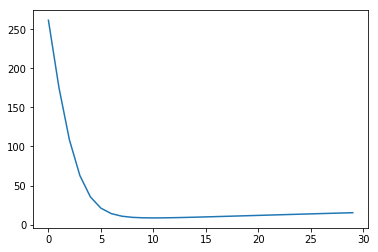

In [6]:
dataset = open("samples_assign4.txt", 'r').readlines()[1:]
np.random.seed(0)
w = [np.random.randn() for i in range(7)]
print("Initial Weights:")
print(w)

num_iterations = 30
history = []

for j in range(num_iterations):
    error = 0
    for line in dataset:
        (x,y) = map(float, line.strip().split(" "))
        (a,z) = forward_propagate(x, w)
        error += (y - a[0])**2
        w = train_step(x, y, w, 0.01)
    history.append(error)
    
print("\nFinal Weights:")
print(w)

epochs = list(range(num_iterations))
plt.plot(epochs, history)

As we can see, the learning is working because the error is going down in every epoch of the training.

# 2. The hangman

Design a function able to find the missing characters from a word. The function must work as follows:

```
>>> hangman("pe_p_e")
'people'

>>> hangman("phi__sop_y")
'philosophy'

>>> hangman("si_nif_c_nc_")
'significance'

>>> hangman("kn__l_d_e")
'knowledge'

>>> hangman("inte_r_ga_i_n")
'interrogation'
```

The function must be able to deal with up to 4 unknowns in arbitrary length words. The function must work in a reasonable time (max 30 seconds in a laptop). 

We are using the model used in the class, which is trained with a Nietzsche text.

In [7]:
path = get_file('nietzsche.txt', origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt")
text = open(path).read().lower()
chars = sorted(list(set(text)))
vocab_size = 57
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
print("Total number of chars:", len(text))
print("Vocabulary size:", vocab_size)

606208/600901 [==============================] - 1s 2us/step
Total number of chars: 600893
Vocabulary size: 57


In [8]:
def log_likelihood(model, text):
    probs = model.predict(parse_text(text, vocab_size, padding=True)).squeeze()
    return sum([np.log(probs[i, char_indices[c]]) 
                 for i,c in enumerate(text[1:]) ])

def parse_text(text, vocab_size, padding=False):
    if padding:
        X = np.zeros((1, maxlen, vocab_size), dtype=np.bool)
    else:
        X = np.zeros((1, len(text), vocab_size), dtype=np.bool)
    for t, char in enumerate(text):
        X[0, t, char_indices[char]] = 1
    return X

In [9]:
maxlen = 40
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, vocab_size), return_sequences=True, name="lstm_1"))
model.add(TimeDistributed(Dense(vocab_size), name="dense_1"))#Check names to see how to load weights
model.add(Activation('softmax', name="activation_1"))
h5file = 'lstm-pretrained-weights.hdf5'
optimizer = RMSprop(lr=0.01)
model.load_weights(h5file)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

## Beam Search
To choose the best words, we used a Beam Search approach with a modification. In this approach, for each level we fill an empty space with all the combination of letters of the alphabet, then we make the prediction to obtain the log likelihood for each node and finally we take the $\beta$ best results. In our case, at the first level we take all the nodes, because at that time the tree is not so wide. At the end, we return those $\beta$ best results.

In [36]:
alphabet = "abcdefghijklmnopqrstuvwxyz"
 
def beam_search(word, empty_spaces, width):
    s = ((word, empty_spaces), -1)
    frontier = [s]
    count = 0
    for pos in empty_spaces:
        new_frontier = []
        while frontier:
            cur_node = frontier.pop(0)
            cur_word = cur_node[0][0]
            empty = cur_node[0][1]
            cur_pos = empty[0]
            for char in alphabet:
                child_word = cur_word[:cur_pos] + char + cur_word[cur_pos + 1:]
                prediction = log_likelihood(model, child_word)
                child_node = ((child_word,empty[1:]), prediction)
                new_frontier.append(child_node)
        new_frontier.sort(key=itemgetter(1), reverse=True)
        if count == 0:
            frontier = new_frontier
        elif count == 1:
            frontier = new_frontier[:width]
        else:
            frontier = new_frontier[:width]
        count += 1

    return frontier

We choose a value $\beta = 5$

In [37]:
def hangman(word):
    ### your code here
    empty_spaces = []
    for i in range(len(word)):
        if word[i] == '_':
            empty_spaces.append(i)
    word = str.replace(word, "_", " ")
    best_results = beam_search(word, empty_spaces, 5)
    return best_results
    #return log_likelihood(model, word)

## Test examples

In [38]:
hangman("phi__sop_y")

[(('philosopay', []), -12.201210714876652),
 (('philosophy', []), -12.705522395670414),
 (('philosopey', []), -14.257561542093754),
 (('philosopty', []), -14.326228715479374),
 (('phinosopty', []), -15.19134908914566)]

In [39]:
hangman("si_nif_c_nc_")

[(('significance', []), -16.644860601983964),
 (('significunce', []), -17.164872373454273),
 (('sitnificance', []), -17.7872135322541),
 (('significence', []), -20.550010630860925),
 (('significancy', []), -21.59570995438844)]

In [40]:
hangman("pe_p_e")

[(('peapse', []), -7.607858531177044),
 (('people', []), -9.375611485913396),
 (('peaphe', []), -10.407592171803117),
 (('peaple', []), -10.510804258286953),
 (('peopse', []), -11.720048189163208)]

In [41]:
hangman("kn__l_d_e")

[(('knowledge', []), -12.072935830336064),
 (('knowledne', []), -17.689156855922192),
 (('knesledne', []), -17.929851695895195),
 (('knesledpe', []), -18.320329040288925),
 (('knowludge', []), -18.571546263992786)]

In [42]:
hangman("inte_r_ga_i_n")

[(('intefrigation', []), -21.944310006685555),
 (('intefrogation', []), -25.836700432002544),
 (('intefragation', []), -29.120118674996775),
 (('intefrigatian', []), -30.869161847047508),
 (('intefrogatien', []), -31.533195167779922)]

As we can see, we get good results for almost all the puzzles (being at the top 5), except for interrogation, which is 

# 3. Bird classification. 

1. Direct prediction
   * Download the dataset birds from http://www-cvr.ai.uiuc.edu/ponce_grp/data/.
   * Use [Keras](https://keras.io/) and the [MobileNet](https://keras.io/applications/#mobilenet) pre-trained model, to classify the images in the birds dataset. Construct a confusion matrix that relates the bird classes with the 10 most frequent classes from ImageNet predicted by the model.
2. Transfer learning
   * Use the pre-trained MobileNet model as a feature extractor. Create a new model that replaces the top part of MobileNet with two layers of 256 and 6 neurons respectively.
   * Change the attribute trainable of the other layers to be False. This will prevent the weights of these layers to be changed during training.
   * Train the model with the training images from the bird dataset. 
   * Evaluate the performance over the test dataset reporting the results in a confusion matrix. Discuss the results. 
3. Fine tuning
   * Repeat the experiment from the last question, but this time allow all the layers to be trained. 
   * Compare and discuss the results.

## 1. Direct Prediction

### Loading the model

In [73]:
model = MobileNet(weights='imagenet')

In [7]:
def predict(img_path):    
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return decode_predictions(preds, top=3)[0][0][1]

In [8]:
d = {}
for i in range(6):
    for j in range(1,101):
        s = predict(folders[i]+str(j).zfill(3)+".jpg")
        if s in d:
            d[s] += 1
        else:
            d[s] = 1

In [9]:
sd = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
ten = []
for i in range(min(len(sd), 10)):
    ten.append(sd[i][0])

Let's going to predice some images with the imageNet Network without being modified.

In [10]:
true = []
pred = []
for i in range(6):
    for j in range(1,101):
        s = predict(folders[i]+str(j).zfill(3)+".jpg")
        if s in ten:
            pred.append(s)
        else:
            pred.append("other")
        true.append(birds[i])

In [11]:
for j in range(6):
    for i in range(j*100,(j+1)*100):
        print(true[i], "\t", pred[i])

toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	

In [12]:
def plot_confusion_matrix(cm, xclasses, yclasses, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    xtick_marks = np.arange(len(xclasses))
    ytick_marks = np.arange(len(yclasses))
    plt.xticks(xtick_marks, xclasses, rotation=90)
    plt.yticks(ytick_marks, yclasses)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Confussion matrix without training

Confusion matrix, without normalization
[[ 0 91  0  0  0  0  0  0  9  0  0  0  0  0  0]
 [ 0  0  1 80  0  0  0  0 18  0  0  0  0  1  0]
 [18  0  4  0 14  0  0  0 37  0 27  0  0  0  0]
 [ 0  0 16 12  0  8 18  0 19  0  1  0 20  6  0]
 [ 0  0  0  0  0  0  0  0  3  0  0  0 97  0  0]
 [ 0  0  0 97  0  0  1  0  2  0  0  0  0  0  0]]


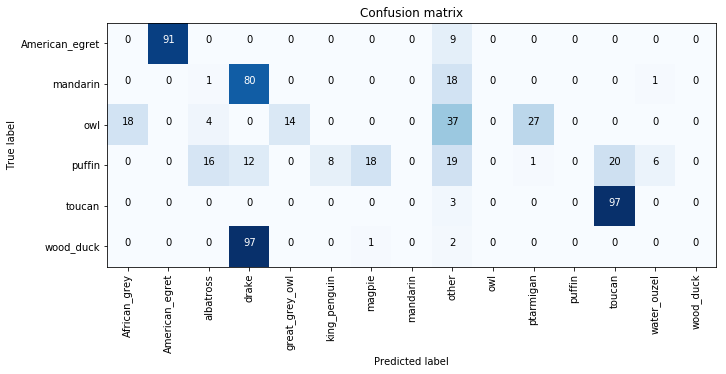

In [13]:
cnf_matrix = confusion_matrix(true, pred)
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
s = set()
for i in ten:
    s.add(i)
for i in birds:
    s.add(i)
s.add("other")
l = sorted(list(s))
indices = []
for i in range(len(l)):
    if l[i] in birds:
        indices.append(i)
plot_confusion_matrix(np.array([[x for x in cnf_matrix[y]] for y in indices]), yclasses=sorted(birds), xclasses=l,
                     normalize=False)

In this matrix, we can see that only Egrets and Toucans are predicted correctly, and Mandarins and Wood Ducks are similar to a kind of duck (Drake).

## 2. Transfer Learning

# Train model with no trainable mobilenet layers
## Train Model without removing layers

The first test we are doing is to just aggregate two new layers to the network (not removing anyone), and just train this layers.

In [69]:
training = 71
validation = 101
birdsNum = 6
epochs = 50
batch_size = 64

layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

def loadImage(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)    
    return preprocess_input(x)

In [70]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 114, 114, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
__________

In [78]:
model2 = models.Sequential()
model2.add(model)

model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(6, activation='softmax'))

for layer in model2.layers[:-3]:
    layer.trainable = False
    
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 1000)              3228864   
_________________________________________________________________
dense_24 (Dense)             (None, 256)               256256    
_________________________________________________________________
dense_25 (Dense)             (None, 6)                 1542      
Total params: 3,486,662
Trainable params: 257,798
Non-trainable params: 3,228,864
_________________________________________________________________


In [40]:
sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer=sgd,
              metrics=['acc'])

In [41]:
x, y, vx, vy = [], [], [], []

for i in range(birdsNum):
    for j in range(1,training):
        x.append(loadImage(folders[i]+str(j).zfill(3)+".jpg"))
        y.append(i)
        
for i in range(birdsNum):
    for j in range(training,validation):
        vx.append(loadImage(folders[i]+str(j).zfill(3)+".jpg"))
        vy.append(i)

x = np.array(x)
y = np.array(y)
vy = np.array(vy)
vx = np.array(vx)
v = (vx, vy)

In [42]:
history = model2.fit(x, y, epochs=epochs, batch_size=batch_size, validation_data=v)

Train on 420 samples, validate on 180 samples
Epoch 1/50
420/420 [==============================] - 3s 7ms/step - loss: 1.7802 - acc: 0.2976 - val_loss: 1.7061 - val_acc: 0.5722
Epoch 2/50
420/420 [==============================] - 1s 3ms/step - loss: 1.7393 - acc: 0.3881 - val_loss: 1.5963 - val_acc: 0.6056
Epoch 3/50
420/420 [==============================] - 1s 3ms/step - loss: 1.6896 - acc: 0.4095 - val_loss: 1.4561 - val_acc: 0.6611
Epoch 4/50
420/420 [==============================] - 1s 3ms/step - loss: 1.6146 - acc: 0.4286 - val_loss: 1.3032 - val_acc: 0.6333
Epoch 5/50
420/420 [==============================] - 1s 3ms/step - loss: 1.5314 - acc: 0.4714 - val_loss: 1.1666 - val_acc: 0.6167
Epoch 6/50
420/420 [==============================] - 1s 2ms/step - loss: 1.4634 - acc: 0.5119 - val_loss: 1.0800 - val_acc: 0.6556
Epoch 7/50
420/420 [==============================] - 1s 3ms/step - loss: 1.3997 - acc: 0.4452 - val_loss: 1.0260 - val_acc: 0.6389
Epoch 8/50
420/420 [==========

Text(0,0.5,'Loss')

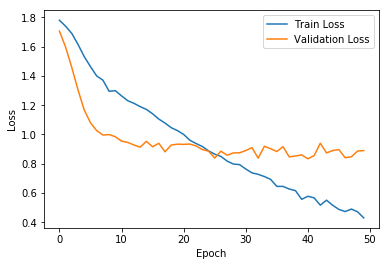

In [43]:
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [44]:
score = model2.evaluate(vx, vy, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8895824270115958
Test accuracy: 0.7777777777777778


### Saving Model

In [45]:
model2.save_weights("model1.h5")

### Confussion matrix

In [46]:
def getPredicted(pred):    
    c, m = 0, 0
    for i in range(pred.shape[1]):
        if pred[0][i] > m:
            m = pred[0][i]
            c = birds[i]
    return c

def predict2(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return getPredicted(model2.predict(x))

In [47]:
true = []
pred = []
for i in range(birdsNum):
    for j in range(training,validation):
        s = predict2(folders[i]+str(j).zfill(3)+".jpg")
        pred.append(s)
        true.append(birds[i]) 

Confusion matrix, without normalization
[[30  0  0  0  0  0]
 [ 0  7  0  0  0 23]
 [ 0  0 29  1  0  0]
 [ 0  4  0 15  7  4]
 [ 0  0  0  0 30  0]
 [ 0  0  0  1  0 29]]


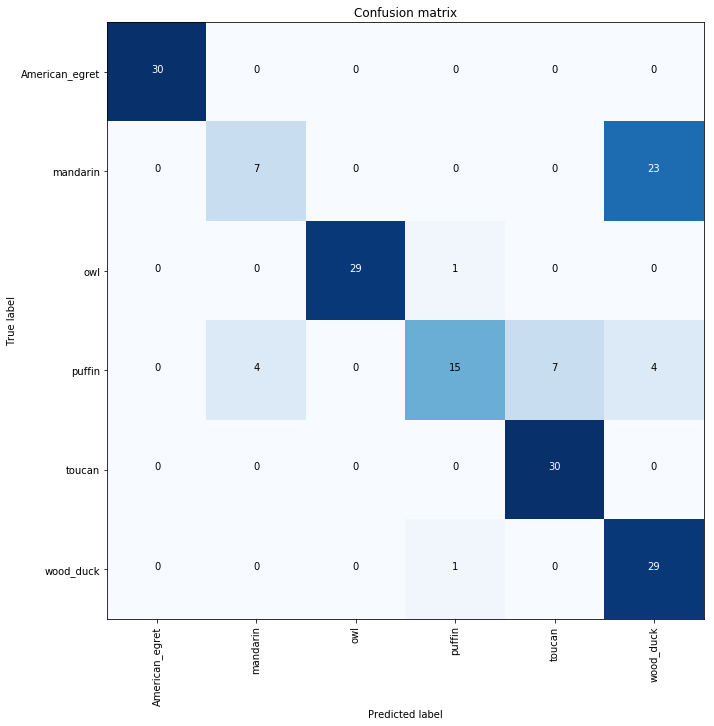

In [48]:
cnf_matrix = confusion_matrix(true, pred)
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))

plot_confusion_matrix(cnf_matrix, yclasses=sorted(birds), xclasses=sorted(birds), normalize=False)

In this matrix we can see that predictions got a lot better, but still Mandarins and Wood Ducks are hard to differentiate and Puffins are not quite clear. By seen, the validation accuracy was stuck at some point of the training as we can see in the history error plot.

## Train Model removing 2 layers till convolutional layer

In this case, we will remove the feedforward layers from ImageNet and just let train the two new added layers.

In [76]:
old_model = model
old_model.layers.pop()
old_model.layers.pop()
old_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 114, 114, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
__________

In [77]:
model2 = models.Sequential()
model2.add(old_model)

model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(6, activation='softmax'))

for layer in model2.layers[:-3]:
    layer.trainable = False
    
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 1000)              3228864   
_________________________________________________________________
dense_22 (Dense)             (None, 256)               256256    
_________________________________________________________________
dense_23 (Dense)             (None, 6)                 1542      
Total params: 3,486,662
Trainable params: 257,798
Non-trainable params: 3,228,864
_________________________________________________________________


In [51]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer=sgd,
              metrics=['acc'])

In [52]:
x, y, vx, vy = [], [], [], []

for i in range(birdsNum):
    for j in range(1,training):
        x.append(loadImage(folders[i]+str(j).zfill(3)+".jpg"))
        y.append(i)
        
for i in range(birdsNum):
    for j in range(training,validation):
        vx.append(loadImage(folders[i]+str(j).zfill(3)+".jpg"))
        vy.append(i)

x = np.array(x)
y = np.array(y)
vy = np.array(vy)
vx = np.array(vx)
v = (vx, vy)

In [53]:
history = model2.fit(x, y, epochs=epochs, batch_size=batch_size, validation_data=v)

Train on 420 samples, validate on 180 samples
Epoch 1/50
420/420 [==============================] - 3s 7ms/step - loss: 1.7901 - acc: 0.1738 - val_loss: 1.7751 - val_acc: 0.2000
Epoch 2/50
420/420 [==============================] - 1s 3ms/step - loss: 1.7848 - acc: 0.2167 - val_loss: 1.7605 - val_acc: 0.4889
Epoch 3/50
420/420 [==============================] - 1s 3ms/step - loss: 1.7765 - acc: 0.2881 - val_loss: 1.7442 - val_acc: 0.5056
Epoch 4/50
420/420 [==============================] - 1s 3ms/step - loss: 1.7706 - acc: 0.3262 - val_loss: 1.7280 - val_acc: 0.4944
Epoch 5/50
420/420 [==============================] - 1s 3ms/step - loss: 1.7618 - acc: 0.3810 - val_loss: 1.7121 - val_acc: 0.5000
Epoch 6/50
420/420 [==============================] - 1s 3ms/step - loss: 1.7557 - acc: 0.3881 - val_loss: 1.6968 - val_acc: 0.5111
Epoch 7/50
420/420 [==============================] - 1s 2ms/step - loss: 1.7500 - acc: 0.4095 - val_loss: 1.6825 - val_acc: 0.5389
Epoch 8/50
420/420 [==========

Text(0,0.5,'Loss')

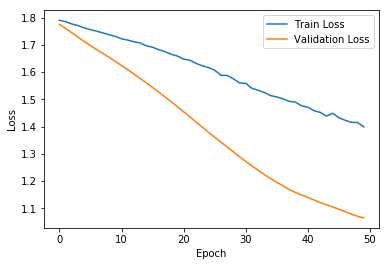

In [54]:
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [55]:
score = model2.evaluate(vx, vy, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.0644341521792942
Test accuracy: 0.7055555542310079


### Saving and Loading Model

In [56]:
model2.save_weights("model2.h5")

### Confusion Matrix

In [57]:
true = []
pred = []
for i in range(birdsNum):
    for j in range(training,validation):
        s = predict2(folders[i]+str(j).zfill(3)+".jpg")
        pred.append(s)
        true.append(birds[i]) 

Confusion matrix, without normalization
[[30  0  0  0  0  0]
 [ 0  0  1  0  0 29]
 [ 0  0 28  1  0  1]
 [ 0  1  0 10  7 12]
 [ 0  0  0  1 29  0]
 [ 0  0  0  0  0 30]]


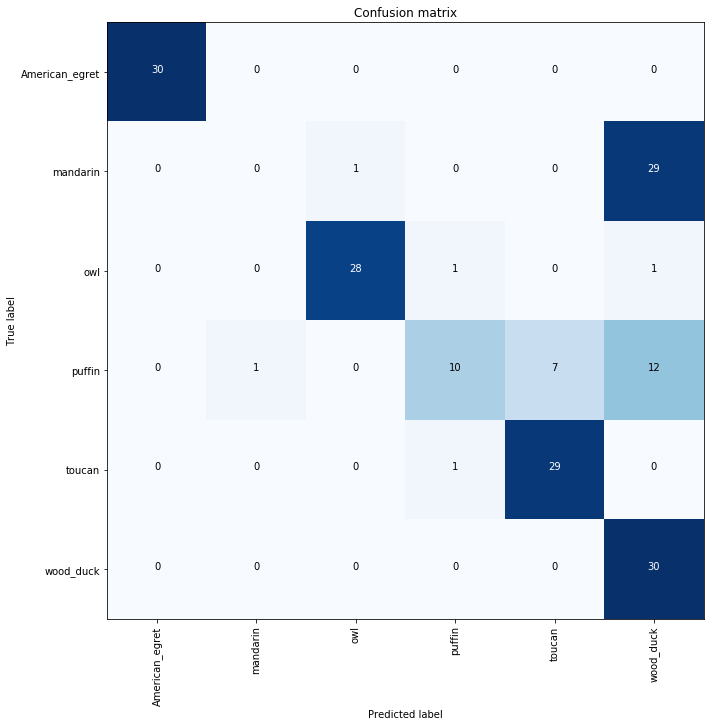

In [58]:
cnf_matrix = confusion_matrix(true, pred)
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))

plot_confusion_matrix(cnf_matrix, yclasses=sorted(birds), xclasses=sorted(birds), normalize=False)

Removing the two layers gave worse results, the problem with Mandarins and Wook Ducks remains, and Puffins had a worse behavior.

## 3. Fine Tuning

## Training all the model

In this case we will let train all the Network

In [79]:
model2 = models.Sequential()
model2.add(old_model)

model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(6, activation='softmax'))

for layer in model2.layers:
    layer.trainable = True
    print(layer, layer.trainable)
    
model2.summary()

<keras.engine.training.Model object at 0x7f0096713160> True
<keras.layers.core.Dense object at 0x7f0096475d30> True
<keras.layers.core.Dense object at 0x7f00964625c0> True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 1000)              3228864   
_________________________________________________________________
dense_26 (Dense)             (None, 256)               256256    
_________________________________________________________________
dense_27 (Dense)             (None, 6)                 1542      
Total params: 3,486,662
Trainable params: 3,464,774
Non-trainable params: 21,888
_________________________________________________________________


In [60]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer=sgd,
              metrics=['acc'])

In [61]:
x, y, vx, vy = [], [], [], []

for i in range(birdsNum):
    for j in range(1,training):
        x.append(loadImage(folders[i]+str(j).zfill(3)+".jpg"))
        y.append(i)
        
for i in range(birdsNum):
    for j in range(training,validation):
        vx.append(loadImage(folders[i]+str(j).zfill(3)+".jpg"))
        vy.append(i)

x = np.array(x)
y = np.array(y)
vy = np.array(vy)
vx = np.array(vx)
v = (vx, vy)

In [62]:
history = model2.fit(x, y, epochs=epochs, batch_size=batch_size, validation_data=v)

Train on 420 samples, validate on 180 samples
Epoch 1/50
420/420 [==============================] - 8s 18ms/step - loss: 1.7871 - acc: 0.2262 - val_loss: 1.7856 - val_acc: 0.3167
Epoch 2/50
420/420 [==============================] - 3s 7ms/step - loss: 1.7790 - acc: 0.3738 - val_loss: 1.7780 - val_acc: 0.3611
Epoch 3/50
420/420 [==============================] - 3s 7ms/step - loss: 1.7627 - acc: 0.4333 - val_loss: 1.7664 - val_acc: 0.3889
Epoch 4/50
420/420 [==============================] - 3s 7ms/step - loss: 1.7408 - acc: 0.4786 - val_loss: 1.7491 - val_acc: 0.4500
Epoch 5/50
420/420 [==============================] - 3s 7ms/step - loss: 1.7096 - acc: 0.5214 - val_loss: 1.7275 - val_acc: 0.4500
Epoch 6/50
420/420 [==============================] - 3s 7ms/step - loss: 1.6732 - acc: 0.5810 - val_loss: 1.7033 - val_acc: 0.4722
Epoch 7/50
420/420 [==============================] - 3s 7ms/step - loss: 1.6328 - acc: 0.6143 - val_loss: 1.6765 - val_acc: 0.5000
Epoch 8/50
420/420 [=========

Text(0,0.5,'Loss')

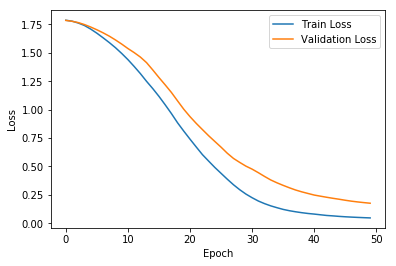

In [63]:
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [64]:
score = model2.evaluate(vx, vy, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1764640481935607
Test accuracy: 0.95


### Saving and loading model

In [65]:
model2.save_weights("model3.h5")

In [67]:
true = []
pred = []
for i in range(birdsNum):
    for j in range(training,validation):
        s = predict2(folders[i]+str(j).zfill(3)+".jpg")
        pred.append(s)
        true.append(birds[i]) 

Confusion matrix, without normalization
[[30  0  0  0  0  0]
 [ 0 30  0  0  0  0]
 [ 0  0 30  0  0  0]
 [ 0  1  0 29  0  0]
 [ 0  7  0  0 23  0]
 [ 0  1  0  0  0 29]]


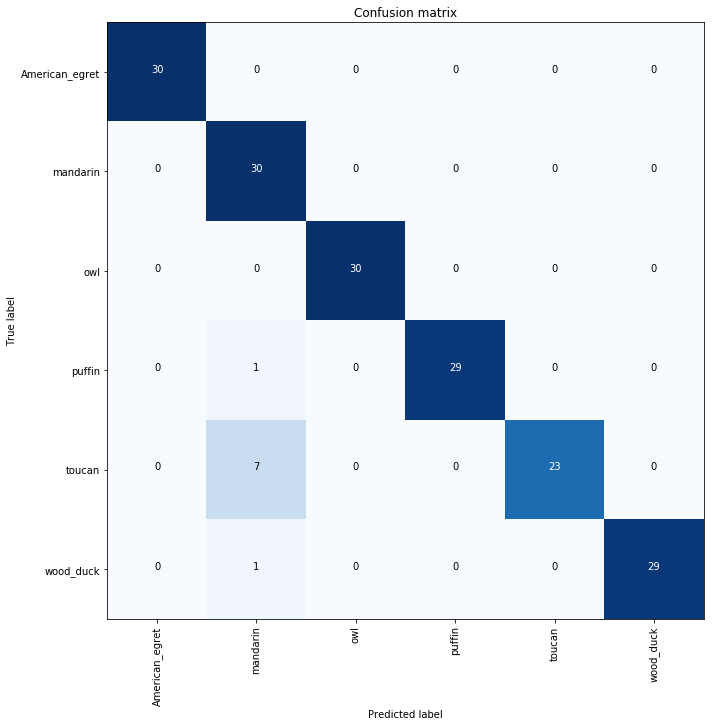

In [68]:
cnf_matrix = confusion_matrix(true, pred)
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))

plot_confusion_matrix(cnf_matrix, yclasses=sorted(birds), xclasses=sorted(birds), normalize=False)

Training all the model was almost perfect, getting a 95% of accuracy. By seen, it was necessary to train some features extracted by the Convolutional Layers. However, there was a trade-off, because toucan in this case got worse, although,it was a better strategy for the global results.
<br><br>
Furthermore, in general we had to add some hyperparameters to get better the training. Some of them were Gradient Descent with Momemtum, Batch Normalization, Learning Rate Decay, an optimal batch-size, and some other.